In [7]:
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import operator

In [8]:
def load_train(data_dir:str) -> pd.DataFrame():
    train_transaction_df = pd.read_csv(os.path.join(data_dir, "train_transaction.csv"))
    train_identity_df = pd.read_csv(os.path.join(data_dir, "train_identity.csv"))
    train_transaction_df = train_transaction_df.merge(train_identity_df,how='left',on='TransactionID')
    return train_transaction_df
train_data=load_train(data_dir="/Users/alexkosa/Desktop/AcLabs/TrainingData")

In [9]:
train_data.drop(['TransactionID'], axis=1, inplace=True)
#train_data=reduce_mem_usage(train_data)

In [8]:
train_data.head(n=10)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
rows=train_data.shape[0]
columns=train_data.shape[1]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB


In [11]:
# 2.77 % of features have more then 90 % of values NaN
sum=0
for col in train_data.columns:
    sum+=train_data[col].isna().sum()/rows>0.90

print(sum/columns*100)


2.771362586605081


DROPPING FEATURES WITH NR OF NANS > 90%

In [12]:
aux=train_data.copy()
aux.drop(aux.columns[aux.apply(lambda col: col.isnull().sum()/rows > 0.90)],axis=1,inplace=True)
aux



,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


TRANSFORM TRANSACTIONDT TO HOUR AND DAY

In [13]:
aux['TransactionHour']=aux['TransactionDT']/3600 % 24
aux['TransactionDay']=aux['TransactionDT']/(3600*24)%7
aux.drop(['TransactionDT'],axis=1,inplace=True)
aux['TransactionHour']

0          0.000000
1          0.000278
2          0.019167
3          0.027500
4          0.029444
            ...    
590535    23.957500
590536    23.958056
590537    23.966389
590538    23.968889
590539    23.980833
Name: TransactionHour, Length: 590540, dtype: float64

In [150]:
aux.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionHour,TransactionDay,DifferentEmailDomain,MissingEmailDomain
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0,1
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000278,1.000012,0,0
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019167,1.000799,0,0
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.027500,1.001146,0,0
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0.029444,1.001227,0,0


In [145]:
aux.select_dtypes(include=["object"]).columns.tolist()

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

ADDING NEW FEATURES

In [14]:
def adding_new_features(aux):
    aux['P_emaildomain'].fillna(value=aux['R_emaildomain'], inplace=True)
    aux['R_emaildomain'].fillna(value=aux['P_emaildomain'], inplace=True)
    aux['P_emaildomain'].fillna(value='missing', inplace=True)
    aux['R_emaildomain'].fillna(value='missing', inplace=True)
    aux['DifferentEmailDomain'] = (aux['P_emaildomain'] != aux['R_emaildomain']).astype(int)
    aux['MissingEmailDomain']=(aux['P_emaildomain']=='missing').astype(int)
    aux.drop(['P_emaildomain'], axis=1, inplace=True)
    aux.drop(['R_emaildomain'], axis=1, inplace=True)
    return aux

In [15]:
aux=adding_new_features(aux)
aux.head(n=10)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionHour,TransactionDay,DifferentEmailDomain,MissingEmailDomain
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0,1
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000278,1.000012,0,0
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019167,1.000799,0,0
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.027500,1.001146,0,0
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0.029444,1.001227,0,0
5,0,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.030556,1.001273,0,0
6,0,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.033889,1.001412,0,0
7,0,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.035833,1.001493,0,0
8,0,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,...,T,F,F,T,mobile,iOS Device,0.037500,1.001562,0,0
9,0,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.037778,1.001574,0,0


In [148]:
aux['DifferentEmailDomain'].sum()

23723

In [149]:
((aux['DifferentEmailDomain']==1) & (aux['isFraud']==1)).sum()/(aux['isFraud'].sum())*100#fraud when different domains


3.300585587765571

Frauds density

<AxesSubplot:ylabel='Density'>

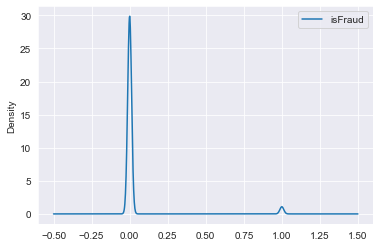

In [42]:
aux.plot(x='TransactionHour',y='isFraud',kind='kde')

In [16]:
aux_isFraud=aux.copy()
aux_isFraud=aux_isFraud.loc[aux_isFraud['isFraud']==True]
aux_isFraud

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionHour,TransactionDay,DifferentEmailDomain,MissingEmailDomain
203,1,445.000,W,18268,583.0,150.0,visa,226.0,credit,251.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.933333,1.038889,0,0
240,1,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,...,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,1.053611,1.043900,0,0
243,1,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,...,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,1.068333,1.044514,0,0
245,1,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,...,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,1.081944,1.045081,0,0
288,1,155.521,C,16578,545.0,185.0,visa,226.0,credit,NaN,...,F,F,F,F,mobile,NaN,1.273889,1.053079,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590361,1,1224.000,W,3278,453.0,150.0,visa,226.0,debit,191.0,...,NaN,NaN,NaN,NaN,NaN,NaN,22.935556,0.955648,0,0
590364,1,69.964,C,5812,408.0,185.0,mastercard,224.0,debit,NaN,...,F,F,T,F,mobile,SAMSUNG SM-J700M Build/MMB29K,22.976667,0.957361,0,0
590368,1,100.000,H,6758,399.0,150.0,american express,146.0,credit,299.0,...,T,F,F,T,mobile,iOS Device,23.021389,0.959225,0,0
590372,1,117.000,W,14037,111.0,150.0,visa,226.0,credit,272.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23.043889,0.960162,0,0


In [44]:
aux_isFraud["TransactionHour"] = np.floor(aux_isFraud["TransactionHour"].astype("float32")).astype("int8").astype("category")

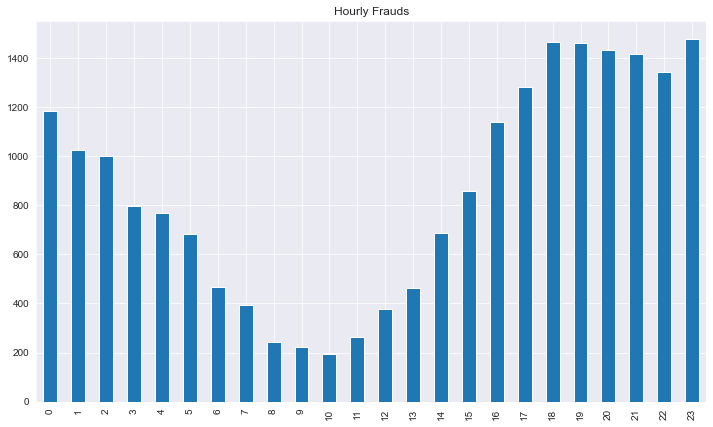

In [45]:
ax = aux_isFraud["TransactionHour"].value_counts().sort_index().plot.bar(figsize=(12, 7))
ax.set_title("Hourly Frauds");

In [46]:
aux_isFraud["TransactionDay"] = np.floor(aux_isFraud["TransactionDay"].astype("float32")).astype("int8").astype("category")

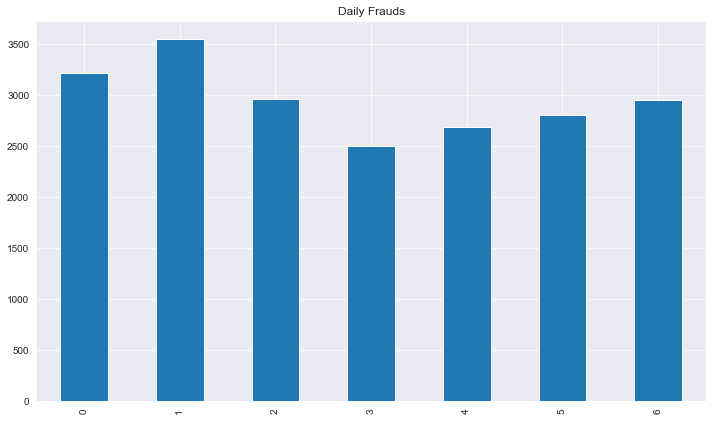

In [47]:
ax = aux_isFraud["TransactionDay"].value_counts().sort_index().plot.bar(figsize=(12, 7))
ax.set_title("Daily Frauds");

BALANCED DATASET

In [17]:
aux_balanced=aux
for i in range(20):
    aux_balanced=pd.concat([aux_balanced,aux_isFraud],ignore_index=True)
aux_balanced

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionHour,TransactionDay,DifferentEmailDomain,MissingEmailDomain
0,0,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0,1
1,0,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000278,1.000012,0,0
2,0,59.000,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019167,1.000799,0,0
3,0,50.000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.027500,1.001146,0,0
4,0,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0.029444,1.001227,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003795,1,1224.000,W,3278,453.0,150.0,visa,226.0,debit,191.0,...,NaN,NaN,NaN,NaN,NaN,NaN,22.935556,0.955648,0,0
1003796,1,69.964,C,5812,408.0,185.0,mastercard,224.0,debit,NaN,...,F,F,T,F,mobile,SAMSUNG SM-J700M Build/MMB29K,22.976667,0.957361,0,0
1003797,1,100.000,H,6758,399.0,150.0,american express,146.0,credit,299.0,...,T,F,F,T,mobile,iOS Device,23.021389,0.959225,0,0
1003798,1,117.000,W,14037,111.0,150.0,visa,226.0,credit,272.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23.043889,0.960162,0,0


<AxesSubplot:ylabel='Density'>

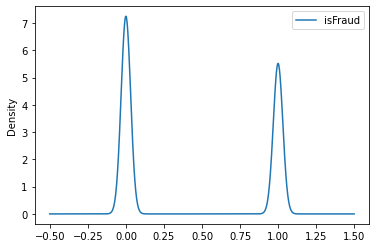

In [20]:
aux_balanced.plot(x='TransactionHour',y='isFraud',kind='kde')

In [18]:
aux_balanced = aux_balanced.sample(frac=1).reset_index(drop=True)
aux_balanced

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionHour,TransactionDay,DifferentEmailDomain,MissingEmailDomain
0,1,150.000,H,4806,490.0,150.0,visa,226.0,debit,315.0,...,T,F,F,T,desktop,MacOS,0.968611,6.040359,0,0
1,1,450.000,H,13749,321.0,150.0,visa,226.0,credit,126.0,...,T,F,T,T,mobile,LM-X210(G,19.345833,5.806076,0,0
2,0,43.142,C,5442,555.0,182.0,visa,226.0,credit,NaN,...,F,F,T,F,desktop,NaN,17.705556,1.737731,0,0
3,0,59.000,W,17482,194.0,150.0,mastercard,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,22.535556,6.938981,0,0
4,1,300.000,H,6021,321.0,150.0,visa,226.0,credit,299.0,...,T,F,T,T,desktop,Windows,16.272778,3.678032,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003795,0,118.020,W,7987,532.0,150.0,mastercard,224.0,debit,158.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23.287500,4.970313,0,0
1003796,1,159.950,W,1724,583.0,150.0,visa,226.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,12.687222,1.528634,0,0
1003797,1,49.555,C,5365,177.0,185.0,mastercard,224.0,credit,NaN,...,F,F,T,T,mobile,Moto Z2 Play Build/NPS26.74-16-1,22.653333,4.943889,0,0
1003798,1,7.251,C,12730,266.0,185.0,mastercard,224.0,credit,NaN,...,F,F,T,F,desktop,Windows,0.121667,0.005069,0,0


Resovle category string features

In [19]:
remain_string=aux.select_dtypes(include=["object"]).columns.tolist()
aux2=aux.copy()
for col in remain_string :
    if len(aux[col].unique()) > 10 :
        aux.drop(col,axis=1,inplace=True)

remain_string=aux.select_dtypes(include=["object"]).columns.tolist()
for col in remain_string:
    aux[col].fillna(value="missing",inplace=True)
    aux=pd.get_dummies(aux,columns=[col])
   # aux.drop(col,axis=1,inplace=True)
aux.head(n=10)


,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_36_missing,id_37_F,id_37_T,id_37_missing,id_38_F,id_38_T,id_38_missing,DeviceType_desktop,DeviceType_missing,DeviceType_mobile
0,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,1.0,...,1,0,0,1,0,0,1,0,1,0
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,1.0,...,1,0,0,1,0,0,1,0,1,0
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,...,1,0,0,1,0,0,1,0,1,0
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,2.0,...,1,0,0,1,0,0,1,0,1,0
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,1.0,...,0,0,1,0,0,1,0,0,0,1
5,0,49.0,5937,555.0,150.0,226.0,272.0,87.0,36.0,1.0,...,1,0,0,1,0,0,1,0,1,0
6,0,159.0,12308,360.0,150.0,166.0,126.0,87.0,0.0,1.0,...,1,0,0,1,0,0,1,0,1,0
7,0,422.5,12695,490.0,150.0,226.0,325.0,87.0,NaN,1.0,...,1,0,0,1,0,0,1,0,1,0
8,0,15.0,2803,100.0,150.0,226.0,337.0,87.0,NaN,1.0,...,0,1,0,0,0,1,0,0,0,1
9,0,117.0,17399,111.0,150.0,224.0,204.0,87.0,19.0,2.0,...,1,0,0,1,0,0,1,0,1,0


In [23]:
aux.select_dtypes(include=["object"]).columns.tolist()

[]

In [20]:
remain_string=aux_balanced.select_dtypes(include=["object"]).columns.tolist()
for col in remain_string :
    if len(aux_balanced[col].unique()) > 10 :
        aux_balanced.drop(col,axis=1,inplace=True)

remain_string=aux_balanced.select_dtypes(include=["object"]).columns.tolist()
for col in remain_string:
    aux_balanced[col].fillna(value="missing",inplace=True)
    aux_balanced=pd.get_dummies(aux_balanced,columns=[col])
   # aux.drop(col,axis=1,inplace=True)
#aux.head(n=10)

FILL NANS

In [154]:
aux

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionHour,TransactionDay,DifferentEmailDomain,MissingEmailDomain
0,0,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0,1
1,0,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000278,1.000012,0,0
2,0,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019167,1.000799,0,0
3,0,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.027500,1.001146,0,0
4,0,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0.029444,1.001227,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23.957500,0.998229,0,1
590536,0,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23.958056,0.998252,0,0
590537,0,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23.966389,0.998600,0,0
590538,0,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23.968889,0.998704,0,0


In [58]:
aux['D1'].isna().sum()

1269

In [157]:
aux.describe()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_36_missing,id_37_F,id_37_T,id_37_missing,id_38_F,id_38_T,id_38_missing,DeviceType_desktop,DeviceType_missing,DeviceType_mobile
count,590540.000000,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,590540.000000,...,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,0.034990,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,14.092458,...,0.761261,0.051704,0.187036,0.761261,0.125177,0.113562,0.761261,0.144215,0.761557,0.094227
std,0.183755,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,133.569018,...,0.426313,0.221428,0.389940,0.426313,0.330920,0.317279,0.426313,0.351308,0.426132,0.292145
min,0.000000,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,3.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,0.000000,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,8.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.000000,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,24.000000,3.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,10286.000000,4685.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [88]:
def print_num_cat_features(df):
    feat=[]
    for col in df.columns:
        if 1.*df[col].value_counts().max()/df[col].count() < 0.5:
            feat.append(col)
    print(feat)

In [89]:
print_num_cat_features(aux)

['TransactionAmt', 'card1', 'card2', 'addr1', 'dist1', 'C9', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D8', 'D9', 'D10', 'D11', 'D15', 'V283', 'id_02', 'id_13', 'id_19', 'id_20', 'TransactionHour', 'TransactionDay']


In [158]:
is_na_columns = aux.isnull().any(axis=0)
columns_with_na = is_na_columns[is_na_columns == True].index
print(is_na_columns)

isFraud               False
TransactionAmt        False
card1                 False
card2                  True
card3                  True
                      ...  
id_38_T               False
id_38_missing         False
DeviceType_desktop    False
DeviceType_missing    False
DeviceType_mobile     False
Length: 474, dtype: bool


In [159]:
aux.isna().sum()

isFraud                  0
TransactionAmt           0
card1                    0
card2                 8933
card3                 1565
                      ... 
id_38_T                  0
id_38_missing            0
DeviceType_desktop       0
DeviceType_missing       0
DeviceType_mobile        0
Length: 474, dtype: int64

In [21]:
aux2=aux.copy()

In [22]:
from typing import Union


def fill_nans2(df: pd.DataFrame, operation: Union[str, float, int] = "mean") -> pd.DataFrame:
    if isinstance(operation, str):
        assert operation in ("mean", "median")

    is_na_columns = df.isnull().any(axis=0)
    columns_with_na = is_na_columns[is_na_columns == True].index
    df_with_nans = df[columns_with_na]
    df_with_nans = df_with_nans.astype("float32")
    if isinstance(operation, str):
        if operation == "mean":
            fill_values = df_with_nans.mean(axis=0, skipna=True)
        else:
            fill_values = df_with_nans.median(axis=0, skipna=True)

        for column in columns_with_na:
            if 1.*df[column].value_counts().max()/df[column].count() < 0.5:
                df[column] = df[column].fillna(fill_values[column])
        for column in columns_with_na:
            df[column] = df[column].fillna(8*df[column].max())
    else:
        fill_value = operation
        df[columns_with_na] = df[columns_with_na].fillna(fill_value)

    return df

In [23]:
aux2=fill_nans2(aux2,'mean')
aux2
aux_balanced=fill_nans2(aux_balanced,'mean')

In [122]:
aux.describe()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_36_missing,id_37_F,id_37_T,id_37_missing,id_38_F,id_38_T,id_38_missing,DeviceType_desktop,DeviceType_missing,DeviceType_mobile
count,590540.000000,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,238269.0,590540.0,...,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,0.034990,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.761261,0.051704,0.187036,0.761261,0.125177,0.113562,0.761261,0.144215,0.761557,0.094227
std,0.183755,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,NaN,NaN,...,0.426313,0.221428,0.389940,0.426313,0.330920,0.317279,0.426313,0.351308,0.426132,0.292145
min,0.000000,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,3.0,1.0,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,0.000000,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,8.0,1.0,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.000000,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,24.0,3.0,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,10288.0,4684.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [123]:
aux2.describe()

/Users/alexkosa/.conda/envs/AcLabs/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/alexkosa/.conda/envs/AcLabs/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/alexkosa/.conda/envs/AcLabs/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/alexkosa/.conda/envs/AcLabs/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/alexkosa/.conda/envs/AcLabs/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/alexkosa/.conda/envs/AcLabs/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeW

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_36_missing,id_37_F,id_37_T,id_37_missing,id_38_F,id_38_T,id_38_missing,DeviceType_desktop,DeviceType_missing,DeviceType_mobile
count,590540.000000,590540.000000,590540.000000,590540.0,590540.0,590540.0,590540.00,590540.0,590540.0,590540.0,...,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,0.034990,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.761261,0.051704,0.187036,0.761261,0.125177,0.113562,0.761261,0.144215,0.761557,0.094227
std,0.183755,NaN,4901.170153,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.426313,0.221428,0.389940,0.426313,0.330920,0.317279,0.426313,0.351308,0.426132,0.292145
min,0.000000,0.250977,1000.000000,100.0,100.0,100.0,100.00,10.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,43.312500,6019.000000,215.0,150.0,166.0,205.00,87.0,13.0,1.0,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,0.000000,68.750000,9678.000000,361.0,150.0,226.0,290.75,87.0,118.5,1.0,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.000000,125.000000,14184.000000,512.0,150.0,226.0,327.00,87.0,118.5,3.0,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,31936.000000,18396.000000,600.0,462.0,474.0,540.00,204.0,10288.0,4684.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [163]:
aux2.isna().sum()

isFraud               0
TransactionAmt        0
card1                 0
card2                 0
card3                 0
                     ..
id_38_T               0
id_38_missing         0
DeviceType_desktop    0
DeviceType_missing    0
DeviceType_mobile     0
Length: 474, dtype: int64

In [126]:
aux2

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_36_missing,id_37_F,id_37_T,id_37_missing,id_38_F,id_38_T,id_38_missing,DeviceType_desktop,DeviceType_missing,DeviceType_mobile
0,0,68.500000,13926,362.5,150.0,142.0,315.0,87.0,19.0,1.0,...,1,0,0,1,0,0,1,0,1,0
1,0,29.000000,2755,404.0,150.0,102.0,325.0,87.0,118.5,1.0,...,1,0,0,1,0,0,1,0,1,0
2,0,59.000000,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,...,1,0,0,1,0,0,1,0,1,0
3,0,50.000000,18132,567.0,150.0,117.0,476.0,87.0,118.5,2.0,...,1,0,0,1,0,0,1,0,1,0
4,0,50.000000,4497,514.0,150.0,102.0,420.0,87.0,118.5,1.0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,49.000000,6550,362.5,150.0,226.0,272.0,87.0,48.0,2.0,...,1,0,0,1,0,0,1,0,1,0
590536,0,39.500000,10444,225.0,150.0,224.0,204.0,87.0,118.5,1.0,...,1,0,0,1,0,0,1,0,1,0
590537,0,30.953125,12037,595.0,150.0,224.0,231.0,87.0,118.5,1.0,...,1,0,0,1,0,0,1,0,1,0
590538,0,117.000000,7826,481.0,150.0,224.0,387.0,87.0,3.0,1.0,...,1,0,0,1,0,0,1,0,1,0


Remove correlated features

In [24]:
corr_mat=aux2.corr().abs()

In [25]:
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool))

In [26]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(len(to_drop))
print(to_drop)

375
['C2', 'C4', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C14', 'D12', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V

In [27]:
aux2.drop(aux2[to_drop],axis=1,inplace=True)
aux2.head(n=15)

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,0,68.500,13926,362.555511,150.0,142.0,315.000000,87.0,19.000000,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0,29.000,2755,404.000000,150.0,102.0,325.000000,87.0,118.502197,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0,59.000,4663,490.000000,150.0,166.0,330.000000,87.0,287.000000,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0,50.000,18132,567.000000,150.0,117.0,476.000000,87.0,118.502197,2.0,...,0,0,0,0,0,0,0,0,0,0
4,0,50.000,4497,514.000000,150.0,102.0,420.000000,87.0,118.502197,1.0,...,0,0,0,1,0,0,0,1,0,1
5,0,49.000,5937,555.000000,150.0,226.0,272.000000,87.0,36.000000,1.0,...,0,0,0,0,0,0,0,0,0,0
6,0,159.000,12308,360.000000,150.0,166.0,126.000000,87.0,0.000000,1.0,...,0,0,0,0,0,0,0,0,0,0
7,0,422.500,12695,490.000000,150.0,226.0,325.000000,87.0,118.502197,1.0,...,0,0,0,0,0,0,0,0,0,0
8,0,15.000,2803,100.000000,150.0,226.0,337.000000,87.0,118.502197,1.0,...,0,0,1,0,0,1,0,1,0,1
9,0,117.000,17399,111.000000,150.0,224.0,204.000000,87.0,19.000000,2.0,...,0,0,0,0,0,0,0,0,0,0


FEATURE SCALLING

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [144]:
scaler = MinMaxScaler()
aux3=scaler.fit_transform(aux2)
aux4=pd.DataFrame(aux3,index=aux2.index,columns=aux2.columns)
aux4

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,0.0,0.002137,0.743044,0.525111,0.138122,0.112299,0.488636,0.396907,0.001847,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000900,0.100885,0.608000,0.138122,0.005348,0.511364,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.001840,0.210566,0.780000,0.138122,0.176471,0.522727,0.396907,0.027902,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.001558,0.984824,0.934000,0.138122,0.045455,0.854545,0.396907,0.011521,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.001558,0.201023,0.828000,0.138122,0.005348,0.727273,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.0,0.001526,0.319039,0.525111,0.138122,0.336898,0.390909,0.396907,0.004667,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590536,0.0,0.001229,0.542883,0.250000,0.138122,0.331551,0.236364,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590537,0.0,0.000961,0.634456,0.990000,0.138122,0.331551,0.297727,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590538,0.0,0.003656,0.392389,0.762000,0.138122,0.331551,0.652273,0.396907,0.000292,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:

aux4.describe()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,...,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,0.034990,0.004220,0.511539,0.525111,0.149208,0.270749,0.433486,0.463097,0.011521,0.003008,...,0.000005,0.000703,0.029424,0.101621,0.011716,0.051704,0.125177,0.113562,0.144215,0.094227
std,0.183755,0.007489,0.281741,0.313190,0.053865,0.126242,0.217987,0.190421,0.022964,0.028510,...,0.002254,0.026500,0.168992,0.302149,0.107606,0.221428,0.330920,0.317279,0.351308,0.292145
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.001349,0.288515,0.230000,0.138122,0.176471,0.238636,0.396907,0.001264,0.000213,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.002145,0.498850,0.522000,0.138122,0.336898,0.433486,0.396907,0.011521,0.000213,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.003906,0.757875,0.824000,0.138122,0.336898,0.515909,0.396907,0.011521,0.000640,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [145]:
aux4['id_34_match_status:minus1']=aux4['id_34_match_status:-1']
aux4.drop('id_34_match_status:-1',axis=1,inplace=True)
import re
aux4 = aux4.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [150]:
X=aux4
X

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_34_match_status0,id_34_match_status1,id_34_match_status2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile,id_34_match_statusminus1
0,0.0,0.002137,0.743044,0.525111,0.138122,0.112299,0.488636,0.396907,0.001847,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000900,0.100885,0.608000,0.138122,0.005348,0.511364,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.001840,0.210566,0.780000,0.138122,0.176471,0.522727,0.396907,0.027902,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.001558,0.984824,0.934000,0.138122,0.045455,0.854545,0.396907,0.011521,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.001558,0.201023,0.828000,0.138122,0.005348,0.727273,0.396907,0.011521,0.000213,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.0,0.001526,0.319039,0.525111,0.138122,0.336898,0.390909,0.396907,0.004667,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590536,0.0,0.001229,0.542883,0.250000,0.138122,0.331551,0.236364,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590537,0.0,0.000961,0.634456,0.990000,0.138122,0.331551,0.297727,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590538,0.0,0.003656,0.392389,0.762000,0.138122,0.331551,0.652273,0.396907,0.000292,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
torch.save(X,'ProcessedTrainingData.csv')

In [149]:
Xloaded=torch.load("ProcessedTrainingData.csv")
Xloaded

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_34_match_status0,id_34_match_status1,id_34_match_status2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile,id_34_match_statusminus1
0,0.0,0.002137,0.743044,0.525111,0.138122,0.112299,0.488636,0.396907,0.001847,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000900,0.100885,0.608000,0.138122,0.005348,0.511364,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.001840,0.210566,0.780000,0.138122,0.176471,0.522727,0.396907,0.027902,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.001558,0.984824,0.934000,0.138122,0.045455,0.854545,0.396907,0.011521,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.001558,0.201023,0.828000,0.138122,0.005348,0.727273,0.396907,0.011521,0.000213,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.0,0.001526,0.319039,0.525111,0.138122,0.336898,0.390909,0.396907,0.004667,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590536,0.0,0.001229,0.542883,0.250000,0.138122,0.331551,0.236364,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590537,0.0,0.000961,0.634456,0.990000,0.138122,0.331551,0.297727,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590538,0.0,0.003656,0.392389,0.762000,0.138122,0.331551,0.652273,0.396907,0.000292,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
Xtrain, Xtest = train_test_split(X, test_size=0.2)

In [98]:
Ytrain=Xtrain['isFraud']
Ytest=Xtest['isFraud']

In [78]:
Ytest

384211    0.0
46531     0.0
168393    0.0
373753    0.0
127449    0.0
         ... 
135150    0.0
212685    0.0
572009    0.0
365913    0.0
361449    0.0
Name: isFraud, Length: 118108, dtype: float64

In [99]:
Xtrain.drop('isFraud',axis=1,inplace=True)
Xtest.drop('isFraud',axis=1,inplace=True)

In [106]:
Xtrain

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C3,...,id_34_match_status0,id_34_match_status1,id_34_match_status2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile,id_34_match_statusminus1
541945,0.003311,0.849333,0.762,0.138122,0.005348,0.522727,0.396907,0.011521,0.001067,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
287156,0.005000,0.757760,0.924,0.138122,0.005348,0.184091,0.396907,0.000486,0.000213,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56195,0.003656,0.650034,0.520,0.138122,0.176471,0.652273,0.396907,0.000875,0.000427,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54046,0.003372,0.736549,0.078,0.138122,0.045455,0.184091,0.396907,0.011521,0.000854,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97316,0.002403,0.210566,0.780,0.138122,0.176471,0.175000,0.396907,0.011521,0.000427,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575254,0.003389,0.290469,0.044,0.138122,0.254011,0.477273,0.396907,0.011521,0.000213,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192198,0.001213,0.061738,0.928,0.138122,0.336898,0.538636,0.396907,0.011521,0.000427,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541201,0.000556,0.276615,0.616,0.234807,0.331551,0.433486,1.000000,0.011521,0.000213,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
257959,0.001840,0.586744,0.522,0.138122,0.336898,0.511364,0.396907,0.002528,0.000640,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
(Ytrain==1).sum()

16446

TRAINNING A MODEL

In [4]:
import lightgbm as lgb

In [5]:
model=lgb.LGBMClassifier()

In [6]:
model.fit(Xtrain,Ytrain)
lgb.plot_importance(model)

NameError: name 'Xtrain' is not defined

In [132]:
Y_test_predict=model.predict(Xtest)
Y_train_preeict=model.predict(Xtrain)

In [3]:
from sklearn.metrics import roc_auc_score

In [133]:
print(roc_auc_score(Ytest,Y_test_predict))
print(roc_auc_score(Ytrain,Y_train_preeict))

0.6915749753756857
0.7037232273792866


TRAINNING BALANCED DATA

In [116]:
corr_mat=aux_balanced.corr().abs()

In [117]:
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool))

In [118]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(len(to_drop))
print(to_drop)

350
['C2', 'C4', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C14', 'D12', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V54', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V96', 'V97', 'V100', 'V101', 'V102', 'V103', 'V105', 'V106', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V118', 'V119', 'V121', 'V122', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146'

In [134]:
aux_balanced.drop(aux_balanced[to_drop],axis=1,inplace=True)
aux_balanced.head(n=15)

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,0,117.000,7919,194.0,150.0,202.0,225.000000,87.0,615.000000,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0,24.000,18018,452.0,150.0,117.0,110.000000,87.0,134.502014,1.0,...,0,0,0,0,0,0,0,0,0,0
2,1,17.082,10876,104.0,185.0,137.0,291.916046,204.0,134.502014,5.0,...,0,0,0,0,0,0,0,1,1,0
3,0,60.000,5195,555.0,150.0,226.0,205.000000,87.0,2.000000,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0,54.500,11157,215.0,150.0,226.0,204.000000,87.0,134.502014,1.0,...,0,0,0,0,0,0,0,0,0,0
5,0,5.377,3154,408.0,185.0,224.0,291.916046,204.0,134.502014,7.0,...,0,0,0,0,0,0,1,0,0,1
6,1,28.858,4504,500.0,185.0,219.0,291.916046,204.0,134.502014,11.0,...,0,0,0,0,0,1,0,1,0,1
7,1,117.000,13484,307.0,150.0,226.0,123.000000,87.0,23.000000,1.0,...,0,0,0,0,0,0,0,0,0,0
8,1,59.000,5853,225.0,150.0,117.0,181.000000,87.0,134.502014,3.0,...,0,0,0,0,0,0,0,0,0,0
9,1,97.000,10011,319.0,150.0,226.0,476.000000,87.0,11.000000,3.0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
aux_balanced

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,0,117.000,7919,194.0,150.0,202.0,225.000000,87.0,615.000000,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0,24.000,18018,452.0,150.0,117.0,110.000000,87.0,134.502014,1.0,...,0,0,0,0,0,0,0,0,0,0
2,1,17.082,10876,104.0,185.0,137.0,291.916046,204.0,134.502014,5.0,...,0,0,0,0,0,0,0,1,1,0
3,0,60.000,5195,555.0,150.0,226.0,205.000000,87.0,2.000000,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0,54.500,11157,215.0,150.0,226.0,204.000000,87.0,134.502014,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003795,0,29.000,16630,242.0,150.0,166.0,184.000000,87.0,134.502014,1.0,...,0,0,0,0,0,0,0,0,0,0
1003796,1,161.083,5365,177.0,185.0,224.0,291.916046,204.0,134.502014,12.0,...,0,0,0,0,0,0,0,1,1,0
1003797,0,72.950,1701,383.0,150.0,226.0,498.000000,87.0,134.502014,1.0,...,0,0,0,0,0,0,0,0,0,0
1003798,1,107.950,10616,583.0,150.0,226.0,110.000000,87.0,134.502014,37.0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
scaler = MinMaxScaler()
aux3=scaler.fit_transform(aux_balanced)
aux_balanced1=pd.DataFrame(aux3,index=aux_balanced.index,columns=aux_balanced.columns)
aux_balanced1

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,0.0,0.003656,0.397735,0.188,0.138122,0.744526,0.284091,0.396907,0.059790,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000744,0.978271,0.704,0.138122,0.124088,0.022727,0.396907,0.013076,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.000527,0.567717,0.008,0.234807,0.270073,0.436173,1.000000,0.013076,0.001067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.001871,0.241147,0.910,0.138122,0.919708,0.238636,0.396907,0.000194,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.001699,0.583870,0.230,0.138122,0.919708,0.236364,0.396907,0.013076,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003795,0.0,0.000900,0.898482,0.284,0.138122,0.481752,0.190909,0.396907,0.013076,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003796,1.0,0.005036,0.250920,0.154,0.234807,0.905109,0.436173,1.000000,0.013076,0.002561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1003797,0.0,0.002276,0.040297,0.566,0.138122,0.919708,0.904545,0.396907,0.013076,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003798,1.0,0.003372,0.552771,0.966,0.138122,0.919708,0.022727,0.396907,0.013076,0.007898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
aux_balanced1['id_34_match_status:minus1']=aux_balanced1['id_34_match_status:-1']
aux_balanced1.drop('id_34_match_status:-1',axis=1,inplace=True)
import re
aux_balanced1 = aux_balanced1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [138]:
X = aux_balanced1
Xtrain, Xtest = train_test_split(X, test_size=0.2)
Ytrain = Xtrain['isFraud']
Ytest = Xtest['isFraud']

In [139]:
Xtrain.drop('isFraud',axis=1,inplace=True)
Xtest.drop('isFraud',axis=1,inplace=True)

In [140]:
Xtrain

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C3,...,id_34_match_status0,id_34_match_status1,id_34_match_status2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile,id_34_match_statusminus1
465350,0.002341,0.849333,0.762000,0.138122,0.014599,0.522727,0.396907,0.013076,0.001067,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
574202,0.012030,0.808577,0.140000,0.138122,0.014599,0.052273,0.396907,0.013076,0.000213,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
945241,0.001040,0.869855,0.022000,0.138122,0.919708,0.452273,0.396907,0.013076,0.000427,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191039,0.001840,0.703265,0.396000,0.138122,0.919708,0.236364,0.396907,0.013076,0.000213,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
629199,0.000643,0.808404,0.527421,0.138122,0.919708,0.436173,1.000000,0.013076,0.000213,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990589,0.001558,0.425730,0.328000,0.138122,0.919708,0.538636,0.396907,0.013076,0.000213,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
69118,0.004689,0.378535,0.906000,0.138122,0.919708,0.384091,0.396907,0.013076,0.000213,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
663545,0.000618,0.922913,0.586000,0.138122,0.124088,0.522727,0.396907,0.013076,0.001281,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
12381,0.002754,0.072201,0.890000,0.234807,0.919708,0.436173,1.000000,0.013076,0.000213,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
Ytrain

465350    0.0
574202    0.0
945241    0.0
191039    0.0
629199    1.0
         ... 
990589    1.0
69118     0.0
663545    0.0
12381     1.0
815098    1.0
Name: isFraud, Length: 803040, dtype: float64

CHECK DATA ENGINEERING WORKS

In [171]:
df1=torch.load("ProcessedTrainingData.csv")
df2=torch.load("ProcessedTrainingData1.csv")

In [172]:
df1

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_34_match_status0,id_34_match_status1,id_34_match_status2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile,id_34_match_statusminus1
0,0.0,0.002137,0.743044,0.525111,0.138122,0.112299,0.488636,0.396907,0.001847,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000900,0.100885,0.608000,0.138122,0.005348,0.511364,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.001840,0.210566,0.780000,0.138122,0.176471,0.522727,0.396907,0.027902,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.001558,0.984824,0.934000,0.138122,0.045455,0.854545,0.396907,0.011521,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.001558,0.201023,0.828000,0.138122,0.005348,0.727273,0.396907,0.011521,0.000213,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.0,0.001526,0.319039,0.525111,0.138122,0.336898,0.390909,0.396907,0.004667,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590536,0.0,0.001229,0.542883,0.250000,0.138122,0.331551,0.236364,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590537,0.0,0.000961,0.634456,0.990000,0.138122,0.331551,0.297727,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590538,0.0,0.003656,0.392389,0.762000,0.138122,0.331551,0.652273,0.396907,0.000292,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
df2

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_34_match_status0,id_34_match_status1,id_34_match_status2,id_36_T,id_37_F,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile,id_34_match_statusminus1
0,0.0,0.002137,0.743044,0.525111,0.138122,0.112299,0.488636,0.396907,0.001847,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000900,0.100885,0.608000,0.138122,0.005348,0.511364,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.001840,0.210566,0.780000,0.138122,0.176471,0.522727,0.396907,0.027902,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.001558,0.984824,0.934000,0.138122,0.045455,0.854545,0.396907,0.011521,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.001558,0.201023,0.828000,0.138122,0.005348,0.727273,0.396907,0.011521,0.000213,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.0,0.001526,0.319039,0.525111,0.138122,0.336898,0.390909,0.396907,0.004667,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590536,0.0,0.001229,0.542883,0.250000,0.138122,0.331551,0.236364,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590537,0.0,0.000961,0.634456,0.990000,0.138122,0.331551,0.297727,0.396907,0.011521,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590538,0.0,0.003656,0.392389,0.762000,0.138122,0.331551,0.652273,0.396907,0.000292,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:

df2.equals(df1)

True